## Feature Selection |Correlation-based feature removal | Random Forest Feature Importance | Mutual Information | 

In [18]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


df_train = pd.read_csv('../Data/FE_reviews_train.csv')
df_test = pd.read_csv('../Data/FE_reviews_test.csv')


print("Shape of df_train:", df_train.shape)
print("Shape of df_test_:", df_test.shape)


df_train.head()


Shape of df_train: (15454, 37)
Shape of df_test_: (3874, 37)


,clothing_id,age,title,review_text,rating,positive_feedback_count,recommended_ind,cleaned_review_text,positive_feedback_count_capped,review_length,...,class_name_Lounge,class_name_Outerwear,class_name_Pants,class_name_Shorts,class_name_Skirts,class_name_Sleep,class_name_Sweaters,class_name_Swim,class_name_Trend,sentiment_score
0,1095,26,Proceed with caution if you are busty!,I absolutely love this dress! it's a great sum...,5,3,1,absolutely love dress great summer dress thats...,3.0,54,...,False,False,False,False,False,False,False,False,False,0.9763
1,850,52,"Love, love, love this tunic!",Perfect little summer tunic that is very flatt...,5,1,1,perfect little summer tunic flattering paired ...,1.0,29,...,False,False,False,False,False,False,False,False,False,0.8942
2,971,27,What happened!,I have never had a purchase go wrong at retail...,1,3,0,never purchase go wrong retailer hesitant spen...,3.0,35,...,False,False,False,False,False,False,False,False,False,0.8383
3,854,37,Nice white top,Beautiful white top. peplum never looged good ...,4,0,1,beautiful white top peplum never looged good f...,0.0,32,...,False,False,False,False,False,False,False,False,False,0.4773
4,867,30,Gorgeous,"I bought this on a whim, and i love it. the co...",5,1,1,bought whim love color much brighter photo wou...,1.0,21,...,False,False,False,False,False,False,False,False,False,0.9451


In [19]:
# Split features (X) and target (y)
X_train_df = df_train.drop(columns=['recommended_ind'])
y_train = df_train['recommended_ind']

X_test_df = df_test.drop(columns=['recommended_ind'])
y_test = df_test['recommended_ind']

text_column = 'cleaned_review_text'
X_train_df[text_column] = X_train_df[text_column].fillna("")
X_test_df[text_column] = X_test_df[text_column].fillna("")

In [20]:
# ALl columns in the training set
all_cols = X_train_df.columns.tolist()

non_numeric_structured_cols = [text_column, 'clothing_id', 'title'] 
if 'Unnamed: 0' in all_cols: 
    non_numeric_structured_cols.append('Unnamed: 0')


In [21]:
# Identify numeric columns that need scaling
numeric_cols_to_scale = ['age', 'positive_feedback_count', 'review_length', 'sentiment_score']
numeric_cols_to_scale = [col for col in numeric_cols_to_scale if col in X_train_df.columns]
one_hot_cols = [col for col in all_cols if col not in non_numeric_structured_cols + numeric_cols_to_scale]

print(f"Numeric columns to scale: {numeric_cols_to_scale}")
print(f"One-hot encoded columns: {one_hot_cols}")

Numeric columns to scale: ['age', 'positive_feedback_count', 'review_length', 'sentiment_score']
One-hot encoded columns: ['review_text', 'rating', 'positive_feedback_count_capped', 'division_name_General Petite', 'division_name_Initmates', 'department_name_Dresses', 'department_name_Intimate', 'department_name_Jackets', 'department_name_Tops', 'department_name_Trend', 'class_name_Casual bottoms', 'class_name_Chemises', 'class_name_Dresses', 'class_name_Fine gauge', 'class_name_Intimates', 'class_name_Jackets', 'class_name_Jeans', 'class_name_Knits', 'class_name_Layering', 'class_name_Legwear', 'class_name_Lounge', 'class_name_Outerwear', 'class_name_Pants', 'class_name_Shorts', 'class_name_Skirts', 'class_name_Sleep', 'class_name_Sweaters', 'class_name_Swim', 'class_name_Trend']


In [22]:
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train_df[numeric_cols_to_scale])
X_test_scaled_numeric = scaler.transform(X_test_df[numeric_cols_to_scale])
X_train_scaled_numeric_df = pd.DataFrame(X_train_scaled_numeric, columns=numeric_cols_to_scale, index=X_train_df.index)
X_test_scaled_numeric_df = pd.DataFrame(X_test_scaled_numeric, columns=numeric_cols_to_scale, index=X_test_df.index)

In [23]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000) 
X_train_tfidf = tfidf.fit_transform(X_train_df[text_column])
X_test_tfidf = tfidf.transform(X_test_df[text_column])

In [24]:
X_train_onehot = X_train_df[one_hot_cols].copy()
X_test_onehot = X_test_df[one_hot_cols].copy()

X_train_onehot = X_train_onehot.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_onehot = X_test_onehot.apply(pd.to_numeric, errors='coerce').fillna(0)

### Correlation-based Feature Removal

In [25]:

X_train_combined = pd.concat(
    [X_train_scaled_numeric_df, X_train_onehot.reset_index(drop=True)], 
    axis=1
)

corr_matrix_train = X_train_combined.corr().abs()

upper_triangle_train = corr_matrix_train.where(
    np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool)
)

to_drop = [column for column in upper_triangle_train.columns if any(upper_triangle_train[column] > 0.85)]

print(f"Structured features to be dropped due to high correlation (> 0.85): {to_drop}")


X_train_structured = X_train_combined.drop(columns=to_drop)

X_test_combined = pd.concat([X_test_scaled_numeric_df, X_test_onehot.reset_index(drop=True)], axis=1)
X_test_structured = X_test_combined.drop(columns=to_drop)

print(f"Structured feature dimensions after correlation removal (train): {X_train_structured.shape}")
print(f"Structured feature dimensions after correlation removal (test): {X_test_structured.shape}")

remaining_structured_feature_names = X_train_structured.columns.tolist()


Structured features to be dropped due to high correlation (> 0.85): ['department_name_Intimate', 'class_name_Dresses', 'class_name_Trend']
Structured feature dimensions after correlation removal (train): (15454, 30)
Structured feature dimensions after correlation removal (test): (3874, 30)


In [26]:
# Ensure all columns in structured DataFrames are numeric
X_train_structured = X_train_structured.apply(pd.to_numeric, errors='coerce').fillna(0)
X_test_structured_selected_df = X_test_structured.apply(pd.to_numeric, errors='coerce').fillna(0)

X_train_combined = hstack([
    X_train_structured.to_numpy(dtype=np.float64),  
    X_train_tfidf
])

X_test_combined = hstack([
    X_test_structured_selected_df.to_numpy(dtype=np.float64),
    X_test_tfidf
])

print(f"Combined data size (training): {X_train_combined.shape}")
print(f"Combined data size (testing): {X_test_combined.shape}")

combined_feature_names = numeric_cols_to_scale + one_hot_cols + tfidf.get_feature_names_out().tolist()
print(f"Total number of combined features: {len(combined_feature_names)}")


Combined data size (training): (15454, 5030)
Combined data size (testing): (3874, 5030)
Total number of combined features: 5033


## Model Building/Training

### Random Forest

In [27]:
rf_selector_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # Thêm class_weight
rf_selector_model.fit(X_train_combined, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [28]:
importances = rf_selector_model.feature_importances_
N_rf = 300  
rf_indices = np.argsort(importances)[-N_rf:]  

X_train_combined_csr = X_train_combined.tocsr()
X_test_combined_csr = X_test_combined.tocsr()

X_trainrf = X_train_combined_csr[:, rf_indices]
X_testrf = X_test_combined_csr[:, rf_indices]  

print(f"Data size after selection using RF Importance (train): {X_trainrf.shape}")
print(f"Data size after selection using RF Importance (test): {X_testrf.shape}")


Data size after selection using RF Importance (train): (15454, 300)
Data size after selection using RF Importance (test): (3874, 300)


### Mutual Information

In [29]:
K_mi = 300 
mi_selector = SelectKBest(mutual_info_classif, k=K_mi)
X_trainmi= mi_selector.fit_transform(X_train_combined, y_train)
X_testmi = mi_selector.transform(X_test_combined) 

mi_indices = mi_selector.get_support(indices=True)
mi_selected_feature_names = [combined_feature_names[i] for i in mi_indices]
print(f"A few features selected by MI: {mi_selected_feature_names[:10]}")


/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

A few features selected by MI: ['sentiment_score', 'rating', 'abby', 'abou', 'activewear', 'actually', 'admit', 'age', 'apron', 'ar']


/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/hoangnhu/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and bin

In [30]:
# Model with Features from Random Forest Importance

rfm_features = RandomForestClassifier(n_estimators=100, random_state=42)
rfm_features.fit(X_trainrf, y_train)


y_pred_rf = rfm_features.predict(X_testrf)
y_proba_rf = rfm_features.predict_proba(X_testrf)[:, 1]


print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")


              precision    recall  f1-score   support

           0       0.82      0.93      0.87       691
           1       0.98      0.95      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.90      0.94      0.92      3874
weighted avg       0.95      0.95      0.95      3874

ROC AUC Score: 0.9894


In [31]:
#Model with Features from Mutual Information 

rfmi_features = RandomForestClassifier(n_estimators=100, random_state=42) 
rfmi_features.fit(X_trainmi, y_train)


y_pred_mi = rfmi_features.predict(X_testmi)
y_proba_mi = rfmi_features.predict_proba(X_testmi)[:, 1]


print("MI:\n", classification_report(y_test, y_pred_mi))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_mi):.4f}")

MI:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87       691
           1       0.98      0.96      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.91      0.94      0.92      3874
weighted avg       0.95      0.95      0.95      3874

ROC AUC Score: 0.9891


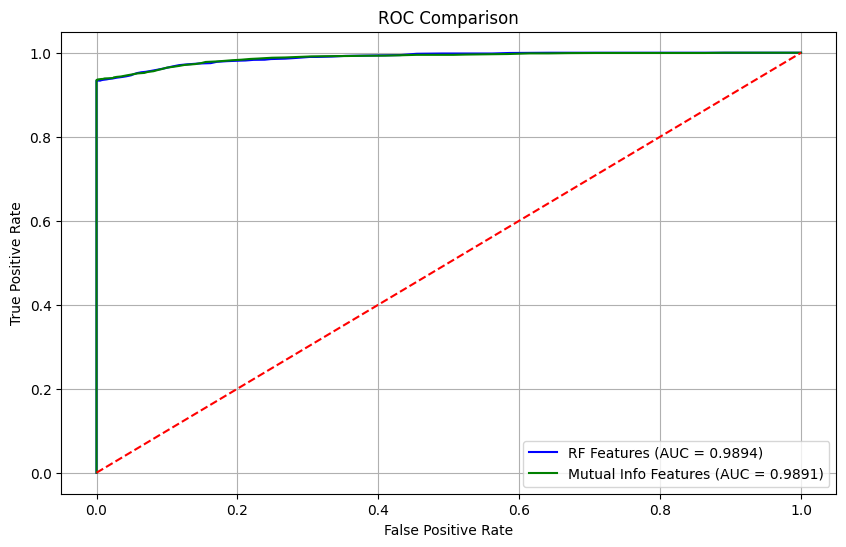

In [32]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf) 
rocrf_val = auc(fpr_rf, tpr_rf) 

fpr_mi, tpr_mi, _ = roc_curve(y_test, y_proba_mi)  
rocmi_val = auc(fpr_mi, tpr_mi)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF Features (AUC = {rocrf_val:.4f})') # 
plt.plot(fpr_mi, tpr_mi, color='green', label=f'Mutual Info Features (AUC = {rocmi_val:.4f})') # 
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Comparison') 
plt.legend(loc='lower right') 
plt.grid(True) 
plt.show() 

In [33]:
# Random Forest Feature Importance
final_imp = rfm_features.feature_importances_


rf_onames = [combined_feature_names[i] for i in rf_indices]

feature_imp = pd.DataFrame({
    'Feature_Original_Name': rf_onames, 
    'Importance': final_imp
})


feature_imp = feature_imp.sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_imp.head(10)) # 



Top 10 Feature Importances:
    Feature_Original_Name  Importance
299                rating    0.474749
298       sentiment_score    0.049566
293              disagree    0.010656
292           longwaisted    0.009698
287                   age    0.008576
290         review_length    0.008326
275                 retro    0.007975
277              retuning    0.007927
289                wallet    0.007758
281                 hubby    0.007309


In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]  
}
GS_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid,
                              cv=3, 
                              scoring='roc_auc',  
                              verbose=2,
                              n_jobs=-1) 

GS_rf.fit(X_trainrf, y_train)

print(f"Best parameters found: {GS_rf.best_params_}")
print(f"Best ROC AUC on validation set (cross-validated): {GS_rf.best_score_:.4f}")

best_rf_model = GS_rf.best_estimator_


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.5s
[CV] END m

In [35]:
bestrf = GS_rf.best_estimator_

bestrf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=42
)
bestrf.fit(X_trainrf, y_train) 

RandomForestClassifier(min_samples_split=10, n_estimators=300, random_state=42)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87       691
           1       0.98      0.96      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.91      0.94      0.92      3874
weighted avg       0.96      0.95      0.95      3874

ROC AUC Score on the Test Set: 0.9899


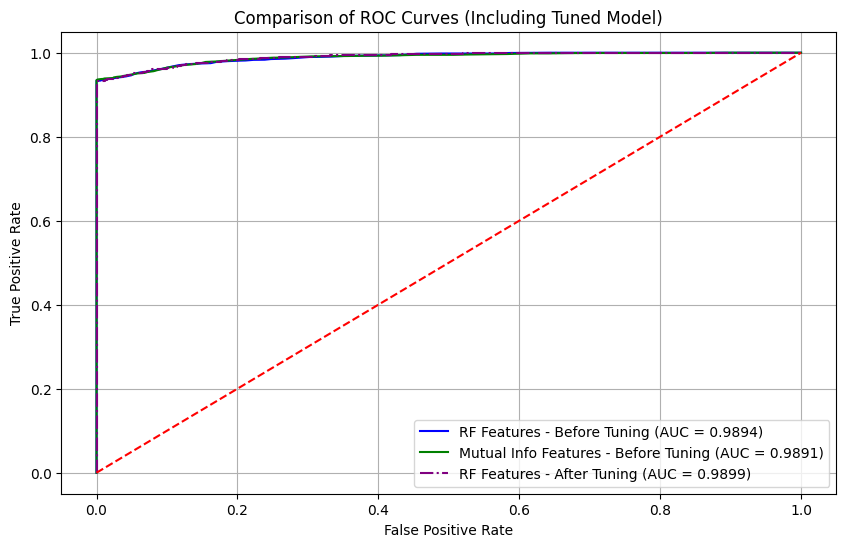

In [36]:
# Predict on the test set
y_pred_best_rf = best_rf_model.predict(X_testrf)
y_proba_best_rf = best_rf_model.predict_proba(X_testrf)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred_best_rf))
print(f"ROC AUC Score on the Test Set: {roc_auc_score(y_test, y_proba_best_rf):.4f}")

fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, y_proba_best_rf)
roc_bestrf_val = auc(fpr_best_rf, tpr_best_rf)

plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', label=f'RF Features - Before Tuning (AUC = {rocrf_val:.4f})') # If you have the old value
plt.plot(fpr_mi, tpr_mi, color='green', label=f'Mutual Info Features - Before Tuning (AUC = {rocmi_val:.4f})') # If available
plt.plot(fpr_best_rf, tpr_best_rf, color='purple', linestyle='-.', label=f'RF Features - After Tuning (AUC = {roc_bestrf_val:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves (Including Tuned Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       691
           1       0.98      0.96      0.97      3183

    accuracy                           0.95      3874
   macro avg       0.91      0.94      0.92      3874
weighted avg       0.96      0.95      0.95      3874

ROC AUC Score (Test Set): 0.9899


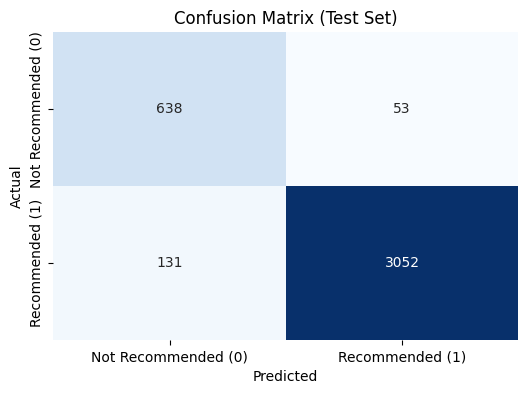

ROC AUC on validation set (cross-validated): 0.9900
ROC AUC on test set: 0.9899


In [37]:
# Predictions on the Test Set
y_pred_test = best_rf_model.predict(X_testrf)
y_proba_test = best_rf_model.predict_proba(X_testrf)[:, 1]

print("Classification Report (Test Set):\n", classification_report(y_test, y_pred_test))
roc_auc_test = roc_auc_score(y_test, y_proba_test)
print(f"ROC AUC Score (Test Set): {roc_auc_test:.4f}")

# Plot
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Recommended (0)', 'Recommended (1)'],
            yticklabels=['Not Recommended (0)', 'Recommended (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()


print(f"ROC AUC on validation set (cross-validated): {GS_rf.best_score_:.4f}") 
print(f"ROC AUC on test set: {roc_auc_test:.4f}")